# Show And Tell

Image captioning is the task of generating textual descriptions or captions for images automatically using machine learning and computer vision techniques.

It combines computer vision, natural language processing, and deep learning to understand the content of images and describe them in natural language.

In this notebook, we explore **Show and Tell**, one of the first end-to-end neural network models for image captioning, introduced in 2015. Uses a CNN encoder and LSTM decoder.

## Introduction

The Show and Tell architecture is a neural network model designed for image captioning. This architecture typically consists of two main components: an Encoder and a Decoder. A convolutional neural network (CNN) is used to extract image features, which are then fed into a recurrent neural network (we use an LSTM in this example) to generate captions for the image.

Paper: [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)


**Load and prepare data**

Use the Flickr30k dataset for testing. This dataset is comprised of 31,783 images of people and events along with a caption for each image.

Source: [UIUC DenotationGraph](http://hockenmaier.cs.illinois.edu/DenotationGraph/data/)


In [19]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import pandas as pd

import torch

from os.path import join

In [20]:
images_path = "archive/Images"
captions_file = "archive/captions.txt"

In [3]:
class Flickr30kDataset(Dataset):
    def __init__(
            self,
            image_path: str,
            captions_file: str
            ) -> None:
        """
        Initialize the Flickr30k dataset.

        Args:
        - image_path (str): Path to the directory containing the images.
        - captions_file (str): Path to the file containing captions.
        """

        self.image_path = image_path
        
        # Load dataset and remove duplicates
        self.dataset = pd.read_csv(captions_file).drop_duplicates('image', ignore_index=True)
        self.dataset['caption'] = self.dataset['caption'].apply(lambda text: text + "." if text[-1] != "." else text)
        
        # Build vocabulary
        self.vocab_tokens = ["<PAD>", "<START>", "<END>"]
        self.vocab_tokens.extend(sorted(list(set(" ".join(self.dataset['caption'].tolist()).split()))))
        
        # Create word-to-index and index-to-word mappings
        self.word_to_index = {word: i for i, word in enumerate(self.vocab_tokens)}
        self.index_to_word = {i: word for i, word in enumerate(self.vocab_tokens)}
        
        self.vocab_size = len(self.vocab_tokens)
        
        # Define image transformations
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]) # Using mean and std of Imagenet is common practice... need to investigate these values more
    
    def __getitem__(self, index):
        
        img = Image.open(join(self.image_path, self.dataset.iloc[index]['image']))
        img = self.transforms(img)
    
        # Process caption
        caption = [self.word_to_index["<START>"]]
        caption.extend([self.word_to_index[word] for word in self.dataset.iloc[index]['caption'].split()])
        caption.append(self.word_to_index["<END>"])
        
        return img, torch.LongTensor(caption), len(caption)
    
    def __len__(self):
        return len(self.dataset)


In [4]:
def pad_collate(batch):
    """
    Pads captions and stacks images in a batch.

    Args:
    - batch (list): A list of tuples (image, caption, caption_length).

    Returns:
    - torch.Tensor: Stacked images tensor.
    - torch.Tensor: Padded captions tensor.
    - list: List of caption lengths.
    """

    # Sort the batch based on caption length in descending order
    sorted_batch = sorted(batch, key=lambda x: x[2], reverse=True)
    
    # Unzip the sorted batch
    imgs, captions, cap_len = zip(*sorted_batch)
    
    # Pad the captions
    caption_padded = pad_sequence(captions, batch_first=True, padding_value=0)
    
    # Convert imgs to tensor and stack them
    imgs = torch.stack(imgs, 0)
    
    return imgs, caption_padded, cap_len

In [5]:
dataset = Flickr30kDataset(images_path, captions_file)

trainloader = DataLoader(
    dataset,
    batch_size = 32,
    collate_fn = pad_collate,
    shuffle = True
    )

## Architecture

- **Encoder (Convolutional Neural Network - CNN):**
  - The Encoder is responsible for extracting features from input images. In the Show and Tell architecture, a pre-trained CNN, such as ResNet or VGG, is commonly used to extract meaningful visual features from images. These features are then passed on to the Decoder for generating captions.
  
- **Decoder (Recurrent Neural Network - RNN):**
  - The decoder takes the visual features from the encoder and generates captions for the corresponding images using an RNN. The decoder processes the visual features along with previously generated words to predict the next word in the caption sequence.
  - At each time step, the decoder generates a word based on the current visual context and the previously generated words. This process continues until an end token is generated or a maximum caption length is reached.
  


In [6]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [219]:
# Define the Encoder
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Freeze all pre-trained weights of the ResNet layers
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # This layer will need to be trained
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        
        self.relu = nn.ReLU()
        self.embed_size = embed_size

    def forward(self, images):
        features = self.resnet(images)
        features = self.relu(features)
        return features
    
# Define the Decoder
class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

## Training

In [220]:
# Instantiate the Encoder and Decoder
embed_size = 256
hidden_size = 512
vocab_size = 10000

encoder = EncoderCNN(embed_size)
decoder = DecoderLSTM(embed_size, hidden_size, vocab_size)

# Define the Loss function and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.resnet.fc.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [223]:
# Training loop
num_epochs = 1
total_step = len(trainloader)
i = 0
for epoch in range(num_epochs):
    for images, captions, caption_lens in trainloader:
        
        # Send images to GPU (if there's one)
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions, caption_lens)

        # Pack the captions for computing the loss
        targets = pack_padded_sequence(captions, caption_lens, batch_first=True)[0]

        # Compute loss
        loss = criterion(outputs, targets)

        # Clear the gradients before backward pass
        optimizer.zero_grad()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        if (i+1) % 5 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        i += 1


Epoch [1/1], Step [5/253], Loss: 8.3627
Epoch [1/1], Step [10/253], Loss: 5.4549
Epoch [1/1], Step [15/253], Loss: 4.8279
Epoch [1/1], Step [20/253], Loss: 4.7772
Epoch [1/1], Step [25/253], Loss: 4.4827
Epoch [1/1], Step [30/253], Loss: 4.5682
Epoch [1/1], Step [35/253], Loss: 4.6601
Epoch [1/1], Step [40/253], Loss: 4.0724
Epoch [1/1], Step [45/253], Loss: 4.5432
Epoch [1/1], Step [50/253], Loss: 4.1092
Epoch [1/1], Step [55/253], Loss: 4.1536
Epoch [1/1], Step [60/253], Loss: 4.2855
Epoch [1/1], Step [65/253], Loss: 4.1237
Epoch [1/1], Step [70/253], Loss: 3.8715
Epoch [1/1], Step [75/253], Loss: 3.8784
Epoch [1/1], Step [80/253], Loss: 4.1370
Epoch [1/1], Step [85/253], Loss: 3.8513
Epoch [1/1], Step [90/253], Loss: 3.6932
Epoch [1/1], Step [95/253], Loss: 3.8387
Epoch [1/1], Step [100/253], Loss: 3.9970
Epoch [1/1], Step [105/253], Loss: 3.6053
Epoch [1/1], Step [110/253], Loss: 3.7179
Epoch [1/1], Step [115/253], Loss: 3.8786
Epoch [1/1], Step [120/253], Loss: 3.7212
Epoch [1/1],

## Test

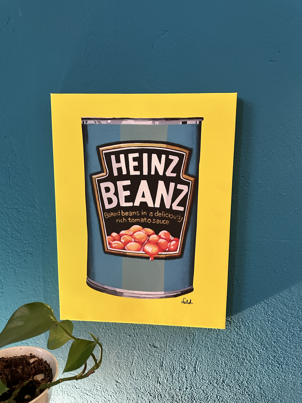

In [23]:
# Load test image
image_path = "images/heinz.jpg"
image = Image.open(image_path).convert('RGB')

scale = 0.1
display(image.resize(( int(image.width * scale), int(image.height * scale))))

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = transform(image).unsqueeze(0) 

# Send image to GPU if available
image = image.to(device)

In [271]:
# Pass the image through the encoder
features = encoder(image)


In [272]:
features = torch.randn(features.shape)
features

tensor([[ 1.3863, -0.2506, -0.1554, -0.6457, -0.2914, -0.4647,  0.8227,  0.9856,
         -0.1986,  2.4134,  1.3133,  0.1668,  2.4734, -0.1343,  0.2518, -0.2173,
         -1.3478, -0.5919, -0.8163,  0.4278, -2.0819,  0.3376, -1.5245,  0.4462,
         -0.2997,  1.7934,  0.6938,  0.5411, -0.0840,  0.2663, -0.3122, -0.2775,
         -1.3744,  0.9011,  0.6059, -0.6084, -0.2534,  1.5323, -1.0919,  0.2650,
          0.8138,  0.0240,  0.0802, -0.2594,  0.6203, -0.8761,  0.1816,  2.6282,
         -1.0944,  0.0128,  0.8233,  0.1401,  0.1529, -0.1399,  0.0745, -0.2520,
         -0.1028,  0.6693, -1.1870, -0.4886, -0.4063,  0.2523, -0.9186, -2.0986,
         -1.1062, -0.3361, -1.0819, -0.7663, -0.1949,  0.0382, -1.3168,  0.8361,
          1.3546,  0.4909,  1.4616,  1.0135,  1.3361,  0.7728,  0.4175,  0.2300,
          0.3360, -0.8414,  0.8923, -1.4560, -0.4009, -0.7363, -0.5102,  0.5183,
         -0.7707,  0.4078,  0.4039,  0.5790,  0.6191, -0.2022, -0.7813,  0.4185,
          0.4506,  0.1782,  

In [284]:
# Define start and end tokens
start_token = dataset.word_to_index['school'] #dataset.word_to_index['<START>']
end_token = dataset.word_to_index['<END>']

# Initialize caption
caption = [start_token]

# Generate caption
max_caption_length = 20
for i in range(max_caption_length):

    # Convert the caption into a tensor
    current_caption = torch.tensor([caption]).to(device)

    # Generate output based on the features and current caption
    output = decoder(features, current_caption, [len(caption)])

    # Get the predicted word index
    _, predicted_index = output.max(1)

    # Append the predicted word index to the caption
    caption.append(predicted_index[-1].item())

    # If the predicted word is the end token, stop generating further words
    if predicted_index[-1].item() == end_token:
        break

# Convert the caption indices to words
predicted_caption = [dataset.index_to_word.get(index, "") for index in caption]

# Join the words to form the final caption
predicted_caption = ' '.join(predicted_caption[1:-1])  # Exclude start and end tokens

# Print the predicted caption
print("Predicted Caption:", predicted_caption)

Predicted Caption:    shirt man and in a a red blue shirt shirt is is standing running on on
